# Project

This project is about weather classification using convolutional neural network.

Dataset link: https://www.kaggle.com/datasets/jehanbhathena/weather-dataset

## Setup

In [ ]:
#!pip install kaggle
!mkdir  ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download jehanbhathena/weather-dataset
!unzip weather-dataset.zip -d .

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import pandas as pd
import seaborn as sns
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet

import os
from PIL import Image

In [ ]:
class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'mish': Mish(mish)})

In [ ]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i][0]])
    plt.show()
    
def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            if activation_index < activation.shape[3]-1:
                activation_index += 1

## Data information

Key insights:
- Dataset is imbalanced.
- Dataset contains 6862 images categorized to 11 classes.
- Class representation ranges from 3.38% to 16.90%.
- Dataset has images with different resolution. Even first quartile has 400x255 image's resolution, but that is too high, so I've tried 32-256x24-192.
- Some images are in grayscale format and some are with alpha channel, so it must be converted to the same type before going on.

### Meta dataset

Creating meta dataset helps with EDA and further image loading.

In [ ]:
dirs = os.listdir("dataset/")
filenames = {dir:[] for dir in dirs}

nof = 0
for dir in dirs:
  filenames[dir] = os.listdir("dataset/" + dir)
  nof += len(filenames[dir])

In [ ]:
df = pd.DataFrame([("dataset/{0}/{1}".format(key, var), key) for (key, L) in filenames.items() for var in L], columns=['file', 'class'])

In [ ]:
df["class_num"] = df["class"].astype("category").cat.codes
df.head()

,file,class,class_num
0,dataset/frost/3653.jpg,frost,2
1,dataset/frost/3842.jpg,frost,2
2,dataset/frost/3943.jpg,frost,2
3,dataset/frost/3636.jpg,frost,2
4,dataset/frost/3938.jpg,frost,2


In [ ]:
shape = (128, 96)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  img_dims[i,0:2] = img.size
  img_dims[i,2] = len(img.getbands())
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
df["width"] = img_dims[:,0]
df["height"] = img_dims[:,1]
df["depth"] = img_dims[:,2]
df.head()

,file,class,class_num,width,height,depth
0,dataset/frost/3653.jpg,frost,2,615.0,513.0,3.0
1,dataset/frost/3842.jpg,frost,2,807.0,538.0,3.0
2,dataset/frost/3943.jpg,frost,2,500.0,749.0,3.0
3,dataset/frost/3636.jpg,frost,2,1024.0,768.0,3.0
4,dataset/frost/3938.jpg,frost,2,640.0,481.0,3.0


In [ ]:
df.shape

(6862, 6)

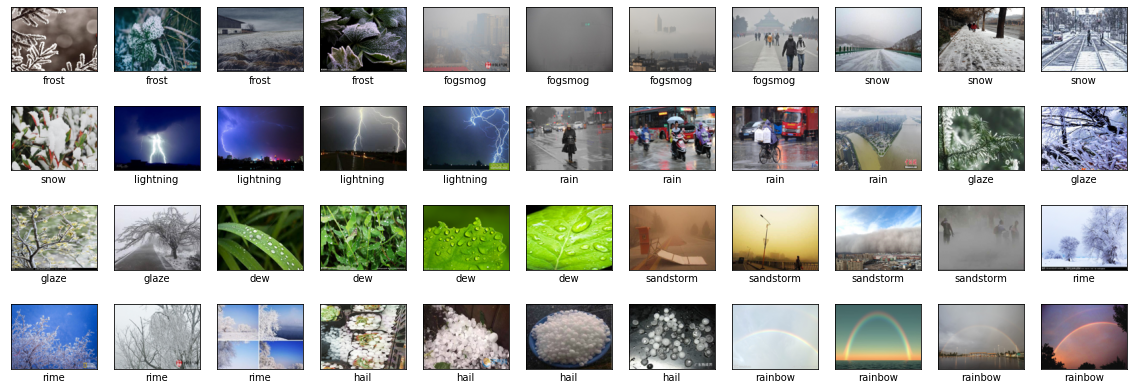

In [ ]:
plt.figure(figsize=(20,7))
idx = 0
for dir in dirs:
  for i, row in df[df["class"] == dir].head(4).iterrows():
      plt.subplot(4, 11, idx+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(X[i], cmap=plt.cm.binary)
      plt.xlabel(dir)
      idx += 1
plt.show()

In [ ]:
df["class_num"].value_counts() / df["class_num"].value_counts().sum() * 100

8     16.904693
1     12.401632
0     10.171962
9     10.084523
3      9.312154
10     9.049840
4      8.612649
6      7.665404
2      6.922180
5      5.494025
7      3.380939
Name: class_num, dtype: float64

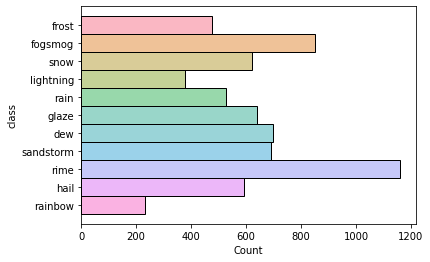

In [ ]:
sns.histplot(data=df, y='class', hue='class', bins=11, legend=False)
plt.show()

In [ ]:
df["depth"].value_counts() / df["depth"].value_counts().sum() * 100

3.0    97.464296
1.0     1.311571
4.0     1.224133
Name: depth, dtype: float64

In [ ]:
df.describe()

,class_num,width,height,depth
count,6862.000000,6862.000000,6862.000000,6862.000000
mean,5.022588,520.029729,373.841737,2.986010
std,3.349520,352.023100,251.419153,0.254004
min,0.000000,117.000000,91.000000,1.000000
25%,2.000000,400.000000,255.000000,3.000000
50%,5.000000,400.000000,280.000000,3.000000
75%,8.000000,500.000000,400.000000,3.000000
max,10.000000,4863.000000,3174.000000,4.000000


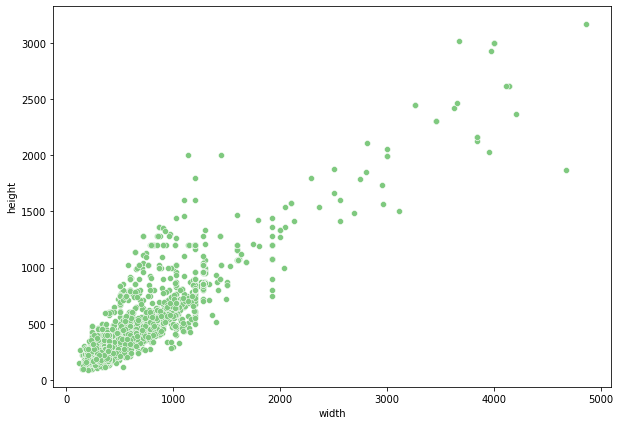

In [ ]:
plt.figure(figsize=(10,7))
sns.set_palette("Accent")
sns.scatterplot(data=df, x="width", y="height")
plt.show()

## Metrics

- I decided to not present accuracy, because dataset is imbalanced
- I decided to present precision, recall and f1-score. Because precision or recall alone can provide misleading information, final comparison metric is going to be tradeoff of these two - f1-score.

## Simple model

| Model | NEURONS | BATCH | IMG SIZE | OPTIMIZER | TIME [s] | F1-score |
|-------|--------:|------:|---------:|-----------|---------:|---------:|
| A     | 32      | 32    | 32,24    | adam      | 21       | 0.6502   |
| B     | 64      | 32    | 32,24    | adam      | 41       | 0.6569   |
| C     | 32      | 32    | 64,48    | adam      | 122      | 0.6243   |
| D     | 32      | 64    | 32,24    | adam      | 22       | 0.6693   |
| E     | 32      | 64    | 32,24    | rmsprop   | 21       | 0.6402   |

- The best and one of the fastest simple models is model D with f1-score 0.6693
- All models performed almost the same with slightly different f1-score. The differences are insignificant.
- The worst model is model C with worst f1-score and even the highest training time.

#### A

- training time **21** s
- f1-score **0.6502**

In [ ]:
shape = (32, 24)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 24, 32, 3) (4940,)
Validation data shape:  (549, 24, 32, 3) (549,)
Test data shape:   (1373, 24, 32, 3) (1373,)


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(shape[1], shape[0], 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(11, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_88 (Conv2D)          (None, 24, 32, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 12, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 12, 16, 64)        18496     
                                                                 
 flatten_34 (Flatten)        (None, 12288)             0         
                                                                 
 dense_68 (Dense)            (None, 128)               1572992   
                                                                 
 dense_69 (Dense)            (None, 11)                1419      
                                                     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/20
155/155 [==============================] - 2s 9ms/step - loss: 1.5179 - accuracy: 0.4895 - val_loss: 1.3624 - val_accuracy: 0.5683
Epoch 2/20
155/155 [==============================] - 1s 8ms/step - loss: 1.0969 - accuracy: 0.6405 - val_loss: 1.1384 - val_accuracy: 0.6412
Epoch 3/20
155/155 [==============================] - 1s 8ms/step - loss: 0.9653 - accuracy: 0.6761 - val_loss: 1.0306 - val_accuracy: 0.6612
Epoch 4/20
155/155 [==============================] - 1s 8ms/step - loss: 0.8850 - accuracy: 0.7020 - val_loss: 1.0835 - val_accuracy: 0.6248
Epoch 5/20
155/155 [==============================] - 1s 8ms/step - loss: 0.7772 - accuracy: 0.7421 - val_loss: 0.9913 - val_accuracy: 0.6740
Epoch 6/20
155/155 [==============================] - 1s 8ms/step - loss: 0.7194 - accuracy: 0.7652 - val_loss: 1.0396 - val_accuracy: 0.6576
Epoch 7/20
155/155 [==============================] - 1s 8ms/step - loss: 0.5974 - accuracy: 0.8085 - val_loss: 1.0024 - val_accuracy: 0.6922
Epoch 

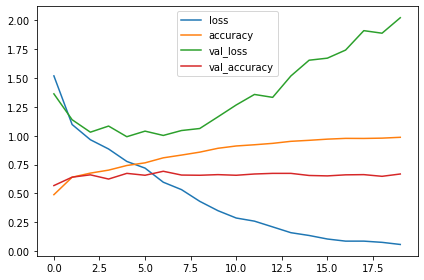

In [ ]:
history = model.fit(train_x, train_y, batch_size=32, validation_data=(valid_x, valid_y), epochs=20, callbacks=[model_checkpoint_callback])

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.6720321410755576
recall		 0.6422332623784125
f1-score	 0.6502325577872559


#### B

- training time **41** s
- f1-score **0.6569**

In [ ]:
shape = (32, 24)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 24, 32, 3) (4940,)
Validation data shape:  (549, 24, 32, 3) (549,)
Test data shape:   (1373, 24, 32, 3) (1373,)


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(shape[1], shape[0], 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(11, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 24, 32, 64)        1792      
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 12, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 12, 16, 128)       73856     
                                                                 
 flatten_35 (Flatten)        (None, 24576)             0         
                                                                 
 dense_70 (Dense)            (None, 256)               6291712   
                                                                 
 dense_71 (Dense)            (None, 11)                2827      
                                                     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/20
155/155 [==============================] - 3s 13ms/step - loss: 1.4661 - accuracy: 0.5059 - val_loss: 1.1558 - val_accuracy: 0.6266
Epoch 2/20
155/155 [==============================] - 2s 11ms/step - loss: 1.0402 - accuracy: 0.6585 - val_loss: 1.0689 - val_accuracy: 0.6466
Epoch 3/20
155/155 [==============================] - 2s 11ms/step - loss: 0.9451 - accuracy: 0.6923 - val_loss: 1.0710 - val_accuracy: 0.6412
Epoch 4/20
155/155 [==============================] - 2s 11ms/step - loss: 0.7935 - accuracy: 0.7346 - val_loss: 1.0031 - val_accuracy: 0.6758
Epoch 5/20
155/155 [==============================] - 2s 10ms/step - loss: 0.6384 - accuracy: 0.7893 - val_loss: 1.0093 - val_accuracy: 0.6812
Epoch 6/20
155/155 [==============================] - 2s 11ms/step - loss: 0.5130 - accuracy: 0.8342 - val_loss: 1.0770 - val_accuracy: 0.6903
Epoch 7/20
155/155 [==============================] - 2s 11ms/step - loss: 0.3654 - accuracy: 0.8850 - val_loss: 1.1645 - val_accuracy: 0.6849

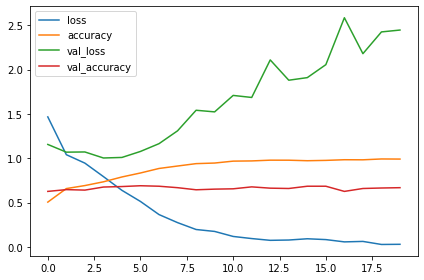

In [ ]:
history = model.fit(train_x, train_y, batch_size=32, validation_data=(valid_x, valid_y), epochs=20, callbacks=[model_checkpoint_callback])

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.7119045446490088
recall		 0.638011255028559
f1-score	 0.656912487196657


#### C

- training time **122** s
- f1-score **0.6243**

In [ ]:
shape = (128, 96)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 96, 128, 3) (4940,)
Validation data shape:  (549, 96, 128, 3) (549,)
Test data shape:   (1373, 96, 128, 3) (1373,)


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(shape[1], shape[0], 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(11, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 96, 128, 32)       896       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 48, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_93 (Conv2D)          (None, 48, 64, 64)        18496     
                                                                 
 flatten_36 (Flatten)        (None, 196608)            0         
                                                                 
 dense_72 (Dense)            (None, 128)               25165952  
                                                                 
 dense_73 (Dense)            (None, 11)                1419      
                                                     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/20
155/155 [==============================] - 8s 45ms/step - loss: 1.7156 - accuracy: 0.4968 - val_loss: 1.0559 - val_accuracy: 0.6557
Epoch 2/20
155/155 [==============================] - 6s 39ms/step - loss: 0.8851 - accuracy: 0.7099 - val_loss: 1.0921 - val_accuracy: 0.6539
Epoch 3/20
155/155 [==============================] - 6s 39ms/step - loss: 0.5643 - accuracy: 0.8221 - val_loss: 1.1012 - val_accuracy: 0.6721
Epoch 4/20
155/155 [==============================] - 6s 39ms/step - loss: 0.2846 - accuracy: 0.9113 - val_loss: 1.1360 - val_accuracy: 0.6922
Epoch 5/20
155/155 [==============================] - 6s 39ms/step - loss: 0.1692 - accuracy: 0.9506 - val_loss: 1.3206 - val_accuracy: 0.7122
Epoch 6/20
155/155 [==============================] - 6s 39ms/step - loss: 0.1369 - accuracy: 0.9581 - val_loss: 1.5896 - val_accuracy: 0.6831
Epoch 7/20
155/155 [==============================] - 6s 40ms/step - loss: 0.1020 - accuracy: 0.9706 - val_loss: 1.8937 - val_accuracy: 0.6557

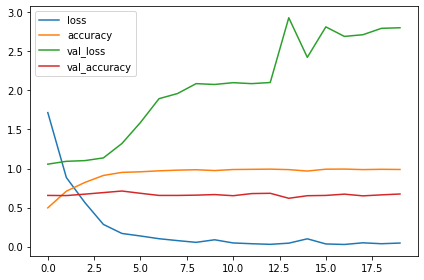

In [ ]:
history = model.fit(train_x, train_y, batch_size=32, validation_data=(valid_x, valid_y), epochs=20, callbacks=[model_checkpoint_callback])

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.6444404241049132
recall		 0.629226825047848
f1-score	 0.624332786948645


#### D

- training time **22** s
- f1-score **0.6693**

In [ ]:
shape = (32, 24)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 24, 32, 3) (4940,)
Validation data shape:  (549, 24, 32, 3) (549,)
Test data shape:   (1373, 24, 32, 3) (1373,)


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(shape[1], shape[0], 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(11, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 24, 32, 32)        896       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 12, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None, 12, 16, 64)        18496     
                                                                 
 flatten_38 (Flatten)        (None, 12288)             0         
                                                                 
 dense_76 (Dense)            (None, 128)               1572992   
                                                                 
 dense_77 (Dense)            (None, 11)                1419      
                                                     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/20
78/78 [==============================] - 3s 17ms/step - loss: 1.6174 - accuracy: 0.4621 - val_loss: 1.3804 - val_accuracy: 0.5373
Epoch 2/20
78/78 [==============================] - 1s 10ms/step - loss: 1.1878 - accuracy: 0.6075 - val_loss: 1.1543 - val_accuracy: 0.6266
Epoch 3/20
78/78 [==============================] - 1s 10ms/step - loss: 1.0006 - accuracy: 0.6700 - val_loss: 1.0372 - val_accuracy: 0.6685
Epoch 4/20
78/78 [==============================] - 1s 9ms/step - loss: 0.9450 - accuracy: 0.6899 - val_loss: 1.0583 - val_accuracy: 0.6594
Epoch 5/20
78/78 [==============================] - 1s 10ms/step - loss: 0.8390 - accuracy: 0.7243 - val_loss: 1.0096 - val_accuracy: 0.6576
Epoch 6/20
78/78 [==============================] - 1s 9ms/step - loss: 0.7951 - accuracy: 0.7381 - val_loss: 1.0467 - val_accuracy: 0.6667
Epoch 7/20
78/78 [==============================] - 1s 9ms/step - loss: 0.7227 - accuracy: 0.7617 - val_loss: 1.0664 - val_accuracy: 0.6485
Epoch 8/20
78/78

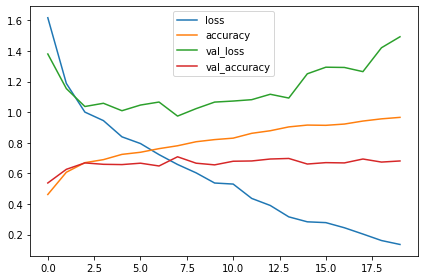

In [ ]:
history = model.fit(train_x, train_y, batch_size=64, validation_data=(valid_x, valid_y), epochs=20, callbacks=[model_checkpoint_callback])

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.6954349537018314
recall		 0.6619017891111271
f1-score	 0.6692502478790899


#### E

- training time **21** s
- f1-score **0.6402**

In [ ]:
shape = (32, 24)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 24, 32, 3) (4940,)
Validation data shape:  (549, 24, 32, 3) (549,)
Test data shape:   (1373, 24, 32, 3) (1373,)


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(shape[1], shape[0], 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(11, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer="rmsprop",
              metrics=['accuracy'])

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 24, 32, 32)        896       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 12, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 12, 16, 64)        18496     
                                                                 
 flatten_39 (Flatten)        (None, 12288)             0         
                                                                 
 dense_78 (Dense)            (None, 128)               1572992   
                                                                 
 dense_79 (Dense)            (None, 11)                1419      
                                                     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/20
78/78 [==============================] - 2s 14ms/step - loss: 1.6702 - accuracy: 0.4480 - val_loss: 1.4628 - val_accuracy: 0.4973
Epoch 2/20
78/78 [==============================] - 1s 11ms/step - loss: 1.2350 - accuracy: 0.5917 - val_loss: 1.3959 - val_accuracy: 0.5355
Epoch 3/20
78/78 [==============================] - 1s 11ms/step - loss: 1.1131 - accuracy: 0.6336 - val_loss: 1.3478 - val_accuracy: 0.5792
Epoch 4/20
78/78 [==============================] - 1s 11ms/step - loss: 1.0252 - accuracy: 0.6599 - val_loss: 1.3787 - val_accuracy: 0.5519
Epoch 5/20
78/78 [==============================] - 1s 11ms/step - loss: 0.9315 - accuracy: 0.6941 - val_loss: 1.3413 - val_accuracy: 0.5483
Epoch 6/20
78/78 [==============================] - 1s 11ms/step - loss: 0.8550 - accuracy: 0.7130 - val_loss: 1.7025 - val_accuracy: 0.4827
Epoch 7/20
78/78 [==============================] - 1s 11ms/step - loss: 0.8015 - accuracy: 0.7387 - val_loss: 2.4926 - val_accuracy: 0.3880
Epoch 8/20
78

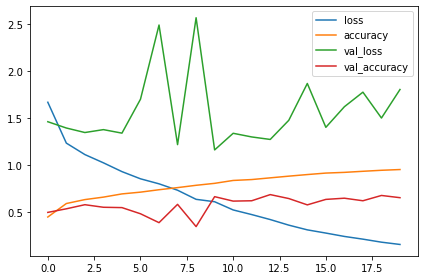

In [ ]:
history = model.fit(train_x, train_y, batch_size=64, validation_data=(valid_x, valid_y), epochs=20, callbacks=[model_checkpoint_callback])

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.7090867430103792
recall		 0.6351674283625212
f1-score	 0.6401577148250065


## Complex model

| Model | NEURONS | BATCH | IMG SIZE | OPTIMIZER | TIME [s] | F1-score |
|------:|--------:|------:|---------:|:----------|---------:|---------:|
|     A |      32 |    64 |    32,24 |      adam | 102      | 0.6864   |
|     B |      64 |    64 |    32,24 |      adam | 205      | 0.6323   |
|     C |      32 |    64 |    128,96|      adam | 903      | 0.6932   |
|     D |      32 |    128|    32,24 |      adam | 113      | 0.6879   |
|     E |      32 |    128|    32,24 |   rmsprop | 105      | 0.6292   |

- The best complex model is model D with f1-score 0.6693, but also with the highest training time.
- In my opinion the best model here is A or D, because of lower training time and not that significant f1-score difference.
- The worst 2 models are model B and E. Those 2 models were outperformed by much simpler models.

#### A

- training time **102** s
- f1-score **0.6864**

In [ ]:
shape = (32, 24)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 24, 32, 3) (4940,)
Validation data shape:  (549, 24, 32, 3) (549,)
Test data shape:   (1373, 24, 32, 3) (1373,)


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='mish', padding="same", input_shape=(shape[1], shape[0], 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(11, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 24, 32, 32)        896       
                                                                 
 batch_normalization_40 (Bat  (None, 24, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_108 (Conv2D)         (None, 24, 32, 32)        9248      
                                                                 
 batch_normalization_41 (Bat  (None, 24, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 12, 16, 32)       0         
 g2D)                                                            
                                                     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/50
78/78 [==============================] - 4s 34ms/step - loss: 1.3490 - accuracy: 0.5632 - val_loss: 2.3312 - val_accuracy: 0.0965
Epoch 2/50
78/78 [==============================] - 2s 32ms/step - loss: 0.9985 - accuracy: 0.6664 - val_loss: 4.0568 - val_accuracy: 0.1494
Epoch 3/50
78/78 [==============================] - 2s 28ms/step - loss: 0.8897 - accuracy: 0.7006 - val_loss: 3.8306 - val_accuracy: 0.1712
Epoch 4/50
78/78 [==============================] - 2s 28ms/step - loss: 0.7917 - accuracy: 0.7306 - val_loss: 4.8014 - val_accuracy: 0.1384
Epoch 5/50
78/78 [==============================] - 2s 28ms/step - loss: 0.7260 - accuracy: 0.7498 - val_loss: 3.1089 - val_accuracy: 0.2605
Epoch 6/50
78/78 [==============================] - 2s 29ms/step - loss: 0.5920 - accuracy: 0.7994 - val_loss: 1.8144 - val_accuracy: 0.4754
Epoch 7/50
78/78 [==============================] - 2s 30ms/step - loss: 0.5236 - accuracy: 0.8215 - val_loss: 1.2527 - val_accuracy: 0.6084
Epoch 8/50
78

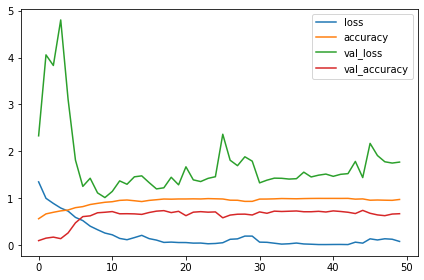

In [ ]:
history = model.fit(train_x, train_y, batch_size=64, validation_data=(valid_x, valid_y), epochs=50, callbacks=[model_checkpoint_callback])

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.7224636512356021
recall		 0.6741891413140166
f1-score	 0.6864177371000979


#### B

- training time **205** s
- f1-score **0.6323**

In [ ]:
shape = (32, 24)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 24, 32, 3) (4940,)
Validation data shape:  (549, 24, 32, 3) (549,)
Test data shape:   (1373, 24, 32, 3) (1373,)


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='mish', padding="same", input_shape=(shape[1], shape[0], 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(11, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_114 (Conv2D)         (None, 24, 32, 64)        1792      
                                                                 
 batch_normalization_48 (Bat  (None, 24, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_115 (Conv2D)         (None, 24, 32, 64)        36928     
                                                                 
 batch_normalization_49 (Bat  (None, 24, 32, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 12, 16, 64)       0         
 g2D)                                                            
                                                     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/50
78/78 [==============================] - 9s 64ms/step - loss: 1.4176 - accuracy: 0.5597 - val_loss: 5.6313 - val_accuracy: 0.1239
Epoch 2/50
78/78 [==============================] - 4s 46ms/step - loss: 1.0795 - accuracy: 0.6342 - val_loss: 5.8493 - val_accuracy: 0.1330
Epoch 3/50
78/78 [==============================] - 4s 46ms/step - loss: 0.9743 - accuracy: 0.6719 - val_loss: 9.2270 - val_accuracy: 0.1311
Epoch 4/50
78/78 [==============================] - 4s 49ms/step - loss: 0.8823 - accuracy: 0.7030 - val_loss: 5.6699 - val_accuracy: 0.1621
Epoch 5/50
78/78 [==============================] - 4s 47ms/step - loss: 0.7683 - accuracy: 0.7399 - val_loss: 2.8935 - val_accuracy: 0.3479
Epoch 6/50
78/78 [==============================] - 4s 47ms/step - loss: 0.6919 - accuracy: 0.7522 - val_loss: 2.7349 - val_accuracy: 0.3752
Epoch 7/50
78/78 [==============================] - 4s 47ms/step - loss: 0.6444 - accuracy: 0.7820 - val_loss: 1.3226 - val_accuracy: 0.5774
Epoch 8/50
78

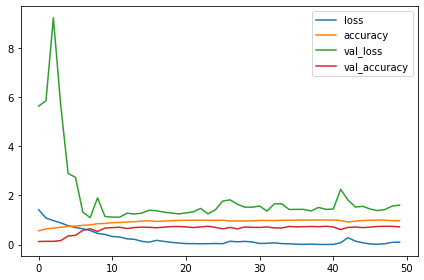

In [ ]:
history = model.fit(train_x, train_y, batch_size=64, validation_data=(valid_x, valid_y), epochs=50, callbacks=[model_checkpoint_callback])

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.6650955686996701
recall		 0.6365413201778259
f1-score	 0.6323458263246267


#### C

- training time **903** s
- f1-score **0.6932**

In [ ]:
shape = (128, 96)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 96, 128, 3) (4940,)
Validation data shape:  (549, 96, 128, 3) (549,)
Test data shape:   (1373, 96, 128, 3) (1373,)


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='mish', padding="same", input_shape=(shape[1], shape[0], 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(11, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_128 (Conv2D)         (None, 96, 128, 32)       896       
                                                                 
 batch_normalization_64 (Bat  (None, 96, 128, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_129 (Conv2D)         (None, 96, 128, 32)       9248      
                                                                 
 batch_normalization_65 (Bat  (None, 96, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 48, 64, 32)       0         
 g2D)                                                            
                                                     

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/50
78/78 [==============================] - 21s 250ms/step - loss: 1.3265 - accuracy: 0.5899 - val_loss: 5.8677 - val_accuracy: 0.1239
Epoch 2/50
78/78 [==============================] - 18s 227ms/step - loss: 0.9062 - accuracy: 0.7030 - val_loss: 8.3161 - val_accuracy: 0.1239
Epoch 3/50
78/78 [==============================] - 18s 227ms/step - loss: 0.7377 - accuracy: 0.7508 - val_loss: 7.1939 - val_accuracy: 0.1348
Epoch 4/50
78/78 [==============================] - 18s 228ms/step - loss: 0.5820 - accuracy: 0.8028 - val_loss: 4.9470 - val_accuracy: 0.1840
Epoch 5/50
78/78 [==============================] - 18s 228ms/step - loss: 0.5754 - accuracy: 0.7986 - val_loss: 2.7110 - val_accuracy: 0.3097
Epoch 6/50
78/78 [==============================] - 18s 228ms/step - loss: 0.5418 - accuracy: 0.8128 - val_loss: 1.6058 - val_accuracy: 0.5501
Epoch 7/50
78/78 [==============================] - 18s 228ms/step - loss: 0.2962 - accuracy: 0.9107 - val_loss: 1.1716 - val_accuracy: 0.6630

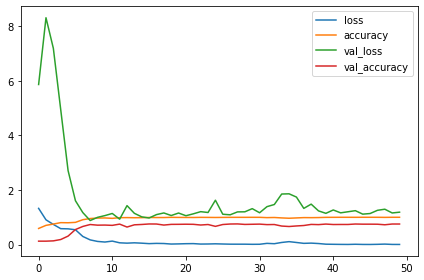

In [ ]:
history = model.fit(train_x, train_y, batch_size=64, validation_data=(valid_x, valid_y), epochs=50, callbacks=[model_checkpoint_callback])

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.7052202133784076
recall		 0.6952385779649398
f1-score	 0.6931640239614157


#### D

- training time **113** s
- f1-score **0.6879**

In [ ]:
shape = (32, 24)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 24, 32, 3) (4940,)
Validation data shape:  (549, 24, 32, 3) (549,)
Test data shape:   (1373, 24, 32, 3) (1373,)


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='mish', padding="same", input_shape=(shape[1], shape[0], 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(11, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 24, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 16, 32)       0         
 )                                                               
                                                        

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/50
39/39 [==============================] - 15s 63ms/step - loss: 1.3491 - accuracy: 0.5652 - val_loss: 2.2954 - val_accuracy: 0.1311
Epoch 2/50
39/39 [==============================] - 2s 43ms/step - loss: 0.9539 - accuracy: 0.6832 - val_loss: 2.3441 - val_accuracy: 0.2641
Epoch 3/50
39/39 [==============================] - 2s 43ms/step - loss: 0.8253 - accuracy: 0.7200 - val_loss: 2.4745 - val_accuracy: 0.1239
Epoch 4/50
39/39 [==============================] - 2s 44ms/step - loss: 0.6894 - accuracy: 0.7711 - val_loss: 3.0208 - val_accuracy: 0.1293
Epoch 5/50
39/39 [==============================] - 2s 46ms/step - loss: 0.5746 - accuracy: 0.8099 - val_loss: 4.8181 - val_accuracy: 0.1421
Epoch 6/50
39/39 [==============================] - 2s 44ms/step - loss: 0.4712 - accuracy: 0.8455 - val_loss: 4.7796 - val_accuracy: 0.1639
Epoch 7/50
39/39 [==============================] - 2s 44ms/step - loss: 0.3608 - accuracy: 0.8883 - val_loss: 3.2534 - val_accuracy: 0.1730
Epoch 8/50
3

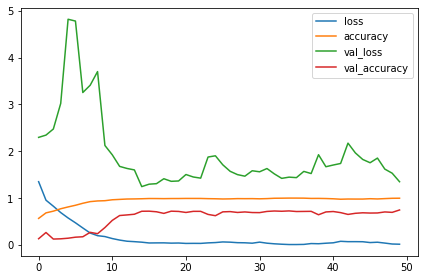

In [ ]:
history = model.fit(train_x, train_y, batch_size=128, validation_data=(valid_x, valid_y), epochs=50, callbacks=[model_checkpoint_callback])

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.7121360874298109
recall		 0.679235891749965
f1-score	 0.6878843485878344


#### E

- training time **105** s
- f1-score **0.6292**

In [ ]:
shape = (32, 24)

X = np.zeros((nof, shape[1], shape[0], 3))
y = np.zeros((nof))

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 24, 32, 3) (4940,)
Validation data shape:  (549, 24, 32, 3) (549,)
Test data shape:   (1373, 24, 32, 3) (1373,)


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='mish', padding="same", input_shape=(shape[1], shape[0], 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='mish', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(11, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 24, 32, 32)        896       
                                                                 
 batch_normalization_16 (Bat  (None, 24, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 32, 32)        9248      
                                                                 
 batch_normalization_17 (Bat  (None, 24, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 16, 32)       0         
 2D)                                                             
                                                      

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/50
39/39 [==============================] - 7s 65ms/step - loss: 1.5564 - accuracy: 0.5174 - val_loss: 2.3791 - val_accuracy: 0.1803
Epoch 2/50
39/39 [==============================] - 2s 51ms/step - loss: 1.1514 - accuracy: 0.6164 - val_loss: 2.6714 - val_accuracy: 0.1239
Epoch 3/50
39/39 [==============================] - 2s 49ms/step - loss: 0.9947 - accuracy: 0.6619 - val_loss: 2.6316 - val_accuracy: 0.2623
Epoch 4/50
39/39 [==============================] - 2s 49ms/step - loss: 0.8588 - accuracy: 0.7022 - val_loss: 4.6947 - val_accuracy: 0.1239
Epoch 5/50
39/39 [==============================] - 2s 50ms/step - loss: 0.7328 - accuracy: 0.7514 - val_loss: 6.6602 - val_accuracy: 0.1239
Epoch 6/50
39/39 [==============================] - 2s 51ms/step - loss: 0.6385 - accuracy: 0.7889 - val_loss: 4.8735 - val_accuracy: 0.1475
Epoch 7/50
39/39 [==============================] - 2s 51ms/step - loss: 0.4658 - accuracy: 0.8383 - val_loss: 5.2600 - val_accuracy: 0.1475
Epoch 8/50
39

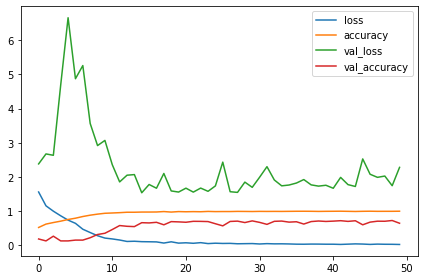

In [ ]:
history = model.fit(train_x, train_y, batch_size=128, validation_data=(valid_x, valid_y), epochs=50, callbacks=[model_checkpoint_callback])

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.6312675524251253
recall		 0.6437950326931655
f1-score	 0.6292434972322122


## Pre-trained models

| Model |    NEURONS   | BATCH | IMG SIZE | MODEL TYPE| TIME [s] | F1-score |
|------:|-------------:|------:|---------:|:----------|---------:|---------:|
|     A | 1024         |   128 |    64,48 | VGG16     | 83       | 0.7086   |
|     B | 1024,512     |    32 |   128,96 | VGG16     | 306      | 0.7936   |
|     C | 1024,512,256 |    32 |  256,192 | VGG16     | 1035     | 0.7847   |
|     D | 1024,512     |    32 |   128,96 | MobileNet | 105      | 0.7785   |
|     E | 1024,512     |   256 |   128,96 | MobileNet | 83       | 0.8438   |
|     F | 512,256      |   256 |   128,96 | MobileNet | 69       | 0.8323   |

- The best pre-trained model and also overall the best model is model E with f1-score 0.8438 and also with very low training time.
- MobileNet model outperforms VGG16 model in this classification task. Also it looks like higher batch size achieves better results.
- The worst models are model A and C. A achieves lowest f1-score and C because of really high training time and average f1-score.
- Even the worst model here outperformes the best of simple models and complex models.

### A

- training time **83** s
- f1-score **0.7086**

In [ ]:
shape = (64, 48)

X = np.zeros((nof, shape[1], shape[0], 3), dtype="float16")
y = np.zeros((nof), dtype="int8")

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 48, 64, 3) (4940,)
Validation data shape:  (549, 48, 64, 3) (549,)
Test data shape:   (1373, 48, 64, 3) (1373,)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(shape[1], shape[0], 3))

x = base_model.output
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(1024, activation='relu')(x)

predictions = keras.layers.Dense(11, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 48, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 16, 128)       0   

Epoch 1/20
39/39 [==============================] - 7s 157ms/step - loss: 1.3166 - accuracy: 0.5597 - val_loss: 1.0694 - val_accuracy: 0.6794
Epoch 2/20
39/39 [==============================] - 4s 104ms/step - loss: 0.8756 - accuracy: 0.7089 - val_loss: 0.9927 - val_accuracy: 0.6612
Epoch 3/20
39/39 [==============================] - 4s 104ms/step - loss: 0.7425 - accuracy: 0.7585 - val_loss: 0.9259 - val_accuracy: 0.7067
Epoch 4/20
39/39 [==============================] - 4s 99ms/step - loss: 0.6573 - accuracy: 0.7862 - val_loss: 0.9437 - val_accuracy: 0.6995
Epoch 5/20
39/39 [==============================] - 4s 104ms/step - loss: 0.6004 - accuracy: 0.7982 - val_loss: 0.8827 - val_accuracy: 0.7104
Epoch 6/20
39/39 [==============================] - 4s 104ms/step - loss: 0.5447 - accuracy: 0.8219 - val_loss: 0.8682 - val_accuracy: 0.7268
Epoch 7/20
39/39 [==============================] - 4s 104ms/step - loss: 0.4890 - accuracy: 0.8462 - val_loss: 0.8527 - val_accuracy: 0.7304
Epoch 8

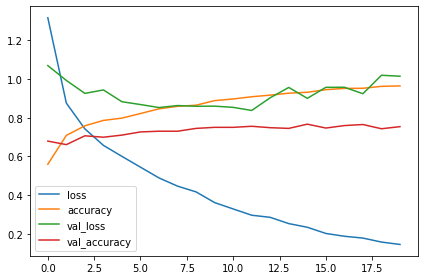

In [ ]:
epochs = 20

history = model.fit(train_x, train_y, batch_size=128, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], epochs=epochs)

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.7234796831724029
recall		 0.7080214325759644
f1-score	 0.7086047130802495


### B

- training time **306** s
- f1-score **0.7936**

In [ ]:
shape = (128, 96)

X = np.zeros((nof, shape[1], shape[0], 3), dtype="float16")
y = np.zeros((nof), dtype='int8')

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 96, 128, 3) (4940,)
Validation data shape:  (549, 96, 128, 3) (549,)
Test data shape:   (1373, 96, 128, 3) (1373,)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(shape[1], shape[0], 3))

x = base_model.output
x = keras.layers.Flatten()(x)

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

predictions = keras.layers.Dense(11, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 128, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 128, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 128, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 32, 128)       0   

Epoch 1/20
155/155 [==============================] - 20s 113ms/step - loss: 1.2339 - accuracy: 0.5755 - val_loss: 0.8194 - val_accuracy: 0.7341
Epoch 2/20
155/155 [==============================] - 15s 100ms/step - loss: 0.7326 - accuracy: 0.7395 - val_loss: 0.7836 - val_accuracy: 0.7250
Epoch 3/20
155/155 [==============================] - 16s 100ms/step - loss: 0.5872 - accuracy: 0.7972 - val_loss: 0.7193 - val_accuracy: 0.7523
Epoch 4/20
155/155 [==============================] - 15s 99ms/step - loss: 0.4961 - accuracy: 0.8285 - val_loss: 0.7487 - val_accuracy: 0.7523
Epoch 5/20
155/155 [==============================] - 15s 100ms/step - loss: 0.4127 - accuracy: 0.8557 - val_loss: 0.6779 - val_accuracy: 0.7978
Epoch 6/20
155/155 [==============================] - 15s 99ms/step - loss: 0.3572 - accuracy: 0.8767 - val_loss: 0.6953 - val_accuracy: 0.8015
Epoch 7/20
155/155 [==============================] - 15s 99ms/step - loss: 0.3387 - accuracy: 0.8777 - val_loss: 0.7519 - val_accur

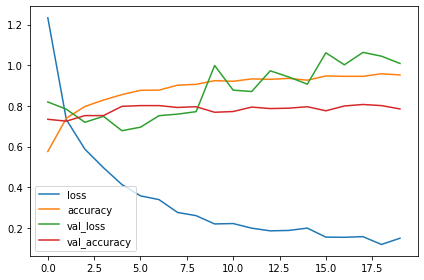

In [ ]:
epochs = 20

history = model.fit(train_x, train_y, batch_size=32, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], epochs=epochs)

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.807573830040801
recall		 0.7954915715138959
f1-score	 0.7935931347112303


### C

- training time **1035** s
- f1-score **0.7847**

In [ ]:
shape = (256, 192)

X = np.zeros((nof, shape[1], shape[0], 3), dtype="float16")
y = np.zeros((nof), dtype="int8")

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 192, 256, 3) (4940,)
Validation data shape:  (549, 192, 256, 3) (549,)
Test data shape:   (1373, 192, 256, 3) (1373,)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(shape[1], shape[0], 3))

x = base_model.output
x = keras.layers.Flatten()(x)

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

predictions = keras.layers.Dense(11, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 128, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 128, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 128, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 64, 128)       0     

Epoch 1/20
155/155 [==============================] - 69s 354ms/step - loss: 1.4865 - accuracy: 0.5107 - val_loss: 0.8467 - val_accuracy: 0.7067
Epoch 2/20
155/155 [==============================] - 51s 330ms/step - loss: 0.7698 - accuracy: 0.7360 - val_loss: 0.6430 - val_accuracy: 0.7887
Epoch 3/20
155/155 [==============================] - 51s 327ms/step - loss: 0.6038 - accuracy: 0.7848 - val_loss: 0.7576 - val_accuracy: 0.7705
Epoch 4/20
155/155 [==============================] - 50s 326ms/step - loss: 0.4655 - accuracy: 0.8429 - val_loss: 0.7024 - val_accuracy: 0.7942
Epoch 5/20
155/155 [==============================] - 51s 326ms/step - loss: 0.4022 - accuracy: 0.8607 - val_loss: 0.7421 - val_accuracy: 0.7869
Epoch 6/20
155/155 [==============================] - 51s 326ms/step - loss: 0.3450 - accuracy: 0.8814 - val_loss: 0.7278 - val_accuracy: 0.7942
Epoch 7/20
155/155 [==============================] - 51s 326ms/step - loss: 0.2763 - accuracy: 0.9024 - val_loss: 0.8337 - val_ac

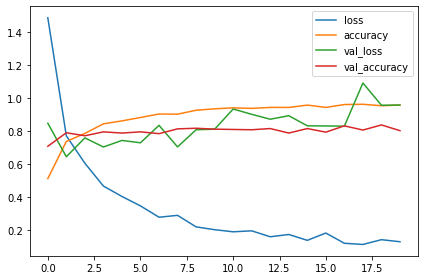

In [ ]:
epochs = 20

history = model.fit(train_x, train_y, batch_size=32, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], epochs=epochs)

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.8146279514224638
recall		 0.7734246599123437
f1-score	 0.7847261473182663


### D

- training time **105** s
- f1-score **0.7785**

In [ ]:
shape = (128, 96)

X = np.zeros((nof, shape[1], shape[0], 3), dtype="float16")
y = np.zeros((nof), dtype="int8")

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 96, 128, 3) (4940,)
Validation data shape:  (549, 96, 128, 3) (549,)
Test data shape:   (1373, 96, 128, 3) (1373,)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(shape[1], shape[0], 3))

x = base_model.output
x = keras.layers.Flatten()(x)

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

predictions = keras.layers.Dense(11, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 128, 3)]      0         
                                                                 
 conv1 (Conv2D)              (None, 48, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 48, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 48, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 48, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 48, 64, 32)       128  

Epoch 1/20
155/155 [==============================] - 10s 43ms/step - loss: 1.4839 - accuracy: 0.6796 - val_loss: 0.7178 - val_accuracy: 0.7650
Epoch 2/20
155/155 [==============================] - 5s 32ms/step - loss: 0.4827 - accuracy: 0.8453 - val_loss: 0.7572 - val_accuracy: 0.7814
Epoch 3/20
155/155 [==============================] - 5s 33ms/step - loss: 0.3012 - accuracy: 0.9030 - val_loss: 0.9423 - val_accuracy: 0.7705
Epoch 4/20
155/155 [==============================] - 5s 33ms/step - loss: 0.1982 - accuracy: 0.9324 - val_loss: 0.7630 - val_accuracy: 0.8251
Epoch 5/20
155/155 [==============================] - 5s 32ms/step - loss: 0.1324 - accuracy: 0.9563 - val_loss: 0.8377 - val_accuracy: 0.8415
Epoch 6/20
155/155 [==============================] - 5s 32ms/step - loss: 0.1187 - accuracy: 0.9674 - val_loss: 0.9946 - val_accuracy: 0.8142
Epoch 7/20
155/155 [==============================] - 5s 32ms/step - loss: 0.1224 - accuracy: 0.9642 - val_loss: 1.1354 - val_accuracy: 0.808

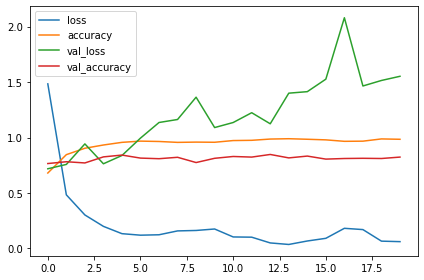

In [ ]:
epochs = 20

history = model.fit(train_x, train_y, batch_size=32, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], epochs=epochs)

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.7980701609897302
recall		 0.776606695151488
f1-score	 0.7785309907569083


### E

- training time **83** s
- f1-score **0.8438**

In [ ]:
shape = (128, 96)

X = np.zeros((nof, shape[1], shape[0], 3), dtype="float16")
y = np.zeros((nof), dtype="int8")

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 96, 128, 3) (4940,)
Validation data shape:  (549, 96, 128, 3) (549,)
Test data shape:   (1373, 96, 128, 3) (1373,)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(shape[1], shape[0], 3))

x = base_model.output
x = keras.layers.Flatten()(x)

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

predictions = keras.layers.Dense(11, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 128, 3)]      0         
                                                                 
 conv1 (Conv2D)              (None, 48, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 48, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 48, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 48, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 48, 64, 32)       128       
 ation)                                                    

Epoch 1/20
20/20 [==============================] - 7s 230ms/step - loss: 3.7764 - accuracy: 0.5036 - val_loss: 0.8122 - val_accuracy: 0.7395
Epoch 2/20
20/20 [==============================] - 4s 191ms/step - loss: 0.6082 - accuracy: 0.8000 - val_loss: 0.6049 - val_accuracy: 0.8179
Epoch 3/20
20/20 [==============================] - 4s 207ms/step - loss: 0.3603 - accuracy: 0.8763 - val_loss: 0.5666 - val_accuracy: 0.8379
Epoch 4/20
20/20 [==============================] - 4s 192ms/step - loss: 0.2292 - accuracy: 0.9225 - val_loss: 0.5523 - val_accuracy: 0.8525
Epoch 5/20
20/20 [==============================] - 4s 183ms/step - loss: 0.1367 - accuracy: 0.9561 - val_loss: 0.6270 - val_accuracy: 0.8506
Epoch 6/20
20/20 [==============================] - 3s 175ms/step - loss: 0.0805 - accuracy: 0.9741 - val_loss: 0.6373 - val_accuracy: 0.8561
Epoch 7/20
20/20 [==============================] - 3s 174ms/step - loss: 0.0500 - accuracy: 0.9866 - val_loss: 0.7138 - val_accuracy: 0.8543
Epoch 

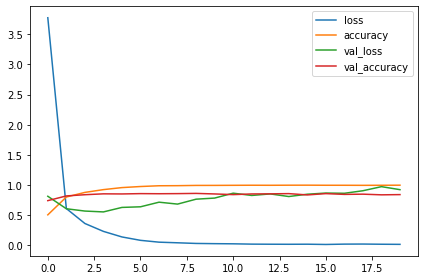

In [ ]:
epochs = 20

history = model.fit(train_x, train_y, batch_size=256, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], epochs=epochs)

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.8499584876407994
recall		 0.844279741633359
f1-score	 0.8438399569399407


### F

- training time **69** s
- f1-score **0.8323**

In [ ]:
shape = (128, 96)

X = np.zeros((nof, shape[1], shape[0], 3), dtype="float16")
y = np.zeros((nof), dtype="int8")

img_dims = np.zeros((nof, 3))

for i, row in df.iterrows():
  img = Image.open(row["file"])
  if len(img.getbands()) != 3:
    img = img.convert("RGB")
  img = img.resize((shape[0], shape[1]))
  img_arr = np.asarray(img)
  X[i] = img_arr / 255.0
  y[i] = row["class_num"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42, stratify=train_y)

print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

Train data shape:  (4940, 96, 128, 3) (4940,)
Validation data shape:  (549, 96, 128, 3) (549,)
Test data shape:   (1373, 96, 128, 3) (1373,)


In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(shape[1], shape[0], 3))

x = base_model.output
x = keras.layers.Flatten()(x)

x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

predictions = keras.layers.Dense(11, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 96, 128, 3)]      0         
                                                                 
 conv1 (Conv2D)              (None, 48, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 48, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 48, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 48, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 48, 64, 32)       128       
 ation)                                                   

Epoch 1/20
20/20 [==============================] - 7s 241ms/step - loss: 2.4007 - accuracy: 0.5233 - val_loss: 0.6828 - val_accuracy: 0.7723
Epoch 2/20
20/20 [==============================] - 4s 186ms/step - loss: 0.5976 - accuracy: 0.8008 - val_loss: 0.5721 - val_accuracy: 0.8069
Epoch 3/20
20/20 [==============================] - 3s 173ms/step - loss: 0.3680 - accuracy: 0.8804 - val_loss: 0.5880 - val_accuracy: 0.8197
Epoch 4/20
20/20 [==============================] - 4s 185ms/step - loss: 0.2347 - accuracy: 0.9233 - val_loss: 0.5574 - val_accuracy: 0.8415
Epoch 5/20
20/20 [==============================] - 3s 172ms/step - loss: 0.1561 - accuracy: 0.9486 - val_loss: 0.5899 - val_accuracy: 0.8251
Epoch 6/20
20/20 [==============================] - 4s 188ms/step - loss: 0.1135 - accuracy: 0.9623 - val_loss: 0.6473 - val_accuracy: 0.8270
Epoch 7/20
20/20 [==============================] - 3s 173ms/step - loss: 0.0813 - accuracy: 0.9727 - val_loss: 0.6740 - val_accuracy: 0.8270
Epoch 

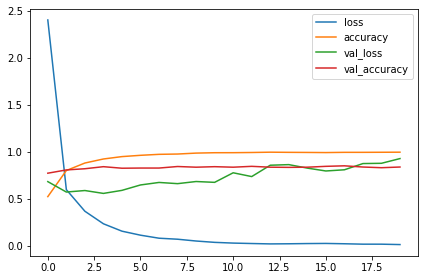

In [ ]:
epochs = 20

history = model.fit(train_x, train_y, batch_size=256, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], epochs=epochs)

show_history(history)

In [ ]:
model.load_weights("weights.best.hdf5")

pred1_y = model.predict(test_x)
pred_y = np.argmax(pred1_y, axis=1)

print("precision\t", precision_score(test_y, pred_y , average="macro"))
print("recall\t\t", recall_score(test_y, pred_y , average="macro"))
print("f1-score\t", f1_score(test_y, pred_y , average="macro"))

precision	 0.8336946575770277
recall		 0.832791531958971
f1-score	 0.8323285214156528


## Summary
- I have tried 16 different models, where pre-trained models outperform my own models.
- Overall the best model was model E from pre-trained models with f1-score 0.8438.
- My own model achieved f1-score 0.6932 but with really high training time compared with pre-trained models.
- I find pre-trained models far more effective than my own created models for this task.
- Here is also normalized confusion matrix by true values for the best achieved model. (model E from pre-trained models)

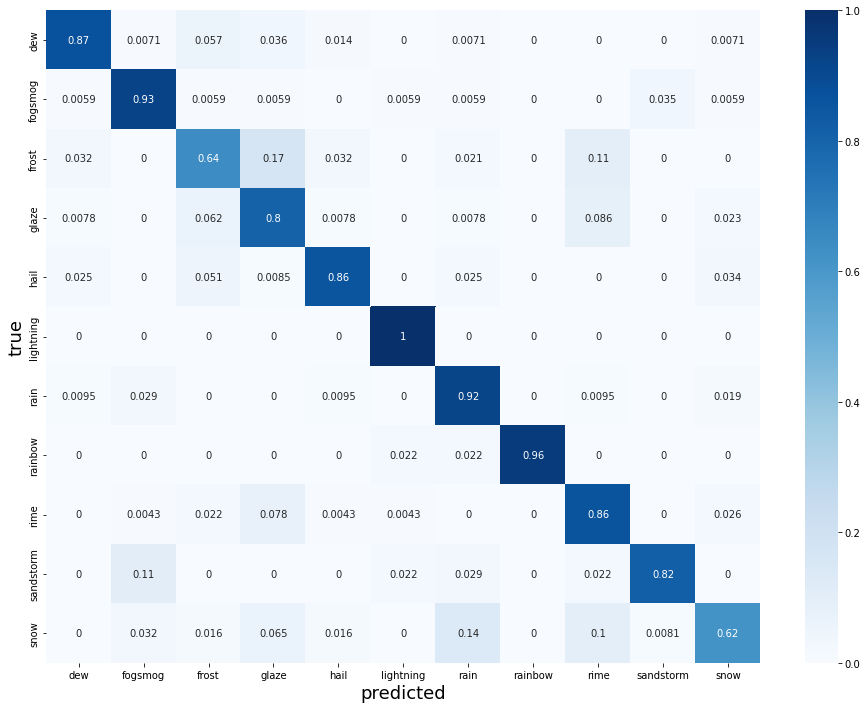

In [ ]:
cm = confusion_matrix(y_true=test_y, y_pred=pred_y, normalize='true')
plt.figure(figsize=(16,12))

sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=sorted(dirs), yticklabels=sorted(dirs))
plt.xlabel('predicted', fontsize=18)
plt.ylabel('true', fontsize=18)
plt.show()